<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/tesis/notebooks/09-seleccion_features_tf-idf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selección de características mediante TF-IDF

__Carrera:__ Maestria en Inteligencia de datos orientada a Big Data de la Universidad Nacional de La Plata.

___Título de la Tesis:___ Clasificación automática de correos electrónicos

___Autor:___ Juan Manuel Fernandez

___Director:___ Marcelo Errecalde

__Objetivo:__ En esta notebook se aplica la estrategia de selección de características basada en TF-IDF para la identificación de términos y features representativos por clase.

## 0. Misceláneos:

### Descarga de librerias necesarias

In [ ]:
!pip install es-lemmatizer
!python -m spacy download es
!pip install requests
!pip install wget

     |████████████████████████████████| 3.2MB 3.8MB/s 
     |████████████████████████████████| 16.2MB 1.3MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-cp37-none-any.whl size=16172935 sha256=88be40caede6d11a45332af770dfbb0c224ab7fa9d78514cd6b1137d2632ccf4
  Stored in directory: /tmp/pip-ephem-wheel-cache-8gh8tsiy/wheels/05/4f/66/9d0c806f86de08e8645d67996798c49e1512f9c3a250d74242
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/es_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/es
You can now load the model via spacy.load('es')
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=e3f999b6a91914f6792bf36160ffa8abeba37441db2a370032e0cb7d91e4ef04
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import consolidar_df

### Descarga dataset de training ya discretizado y con 800 correos etiquetados:

In [ ]:
# Descargo los correos ya etiquetados
from os import path

if not (path.exists('correos-train-jaiio-80.csv')):
    !wget https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/consolidados/correos-train-jaiio-80.csv

--2021-06-15 20:43:21--  https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/consolidados/correos-train-jaiio-80.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238811 (233K) [text/plain]
Saving to: ‘correos-train-jaiio-80.csv’

correos-train-jaiio 100%[===================>] 233.21K  --.-KB/s    in 0.05s   

2021-06-15 20:43:22 (4.90 MB/s) - ‘correos-train-jaiio-80.csv’ saved [238811/238811]



## 1. Presentación del dataset:

### 1.1 Se levanta en un DataFrame para poder manipularlo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargo correos en un dataframe
#correos = pd.read_csv('01-Correos_Seleccionados_y_Etiquetados.csv', sep='|')
correos = pd.read_csv('correos-train-jaiio-80.csv')

# Muestro forma
print(f'Shape = {len(correos)} tuplas x {correos.shape[1]} columnas.\n')

# Muestro top 5
correos.head(3)

Shape = 800 tuplas x 24 columnas.



,consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,clase
0,quería saber por qué no puedo acceder al bolet...,6,2,3,1,2019,2,7,4,1,1,3,4,107,0.0,0.775701,3,21,12,0.952381,0.00000,1,0,Boleto Universitario
1,no puedo reseterar mi clave de acceso al siste...,4,2,12,2,2015,0,2,1,1,1,5,6,419,0.0,0.809069,0,78,45,0.717949,0.00716,1,0,Problemas con la Clave
2,me dice que ya tengo el beneficio de la sube y...,1,2,4,1,2019,3,8,4,1,1,3,6,96,0.0,0.781250,1,22,15,0.863636,0.00000,1,0,Boleto Universitario


### 1.2 Muestro 5 consultas

In [ ]:
# Muestro por completo las primeras 5 consultas
for idx, e in enumerate(correos['consulta'][0:5]):
    print(f'{idx+1} - {e}\n')

1 - quería saber por qué no puedo acceder al boleto estudiantil ya que resido a más de 2000m de la universidad 

2 - no puedo reseterar mi clave de acceso al sistema web ya que ayer me dieron una clave nueva para poder hacerlo, pero no puedo hacerlo ya que me pide primero la clave actual el cual no me lo acuerdo asi que es imposible lograrlo como puedo entonces acceder de otra manera sin que me pida la clave actual? por favor espero me respondan a la brevedad ya que necesito inscribirme para los finales de diciembre. atte liliana 

3 - me dice que ya tengo el beneficio de la sube y no lo tengo quiero saber en que situación estoy  

4 - buenos días, quería consultar cuando me puedo anotar para el taller de febrero, yo estoy por reintegrarme a la universidad para licenciatura en administración me dijeron que tenia q hacer un taller, ya entregue toda la documentación que tenia que presentar y el formulario de reintegro. quería saber hasta cuando me puedo anotar y como lo puedo hacer via i

### 1.3 Escalado de los datos

In [ ]:
# Escalado Min-Max
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Mantengo el tipo de dato DataFrame
correos[correos.columns.difference(['consulta', 'clase'])] = pd.DataFrame(scaler.fit_transform(correos[correos.columns.difference(['consulta', 'clase'])]), columns=correos.columns.difference(['consulta', 'clase']))

correos.head(2)

,consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,clase
0,quería saber por qué no puedo acceder al bolet...,1.000000,0.25,0.181818,0.0,1.0,0.666667,0.857143,1.00,1.0,1.0,0.051724,0.307692,0.200883,0.0,0.547724,0.25,0.18,0.148649,0.929252,0.000000,0.0,0.0,Boleto Universitario
1,no puedo reseterar mi clave de acceso al siste...,0.666667,0.25,1.000000,1.0,0.0,0.000000,0.142857,0.25,1.0,1.0,0.086207,0.461538,0.889625,0.0,0.664658,0.00,0.75,0.594595,0.580952,0.079952,0.0,0.0,Problemas con la Clave


## 2. Análisis Exploratorio de Datos:


### 2.1 Presentación de la distribución de *clase*


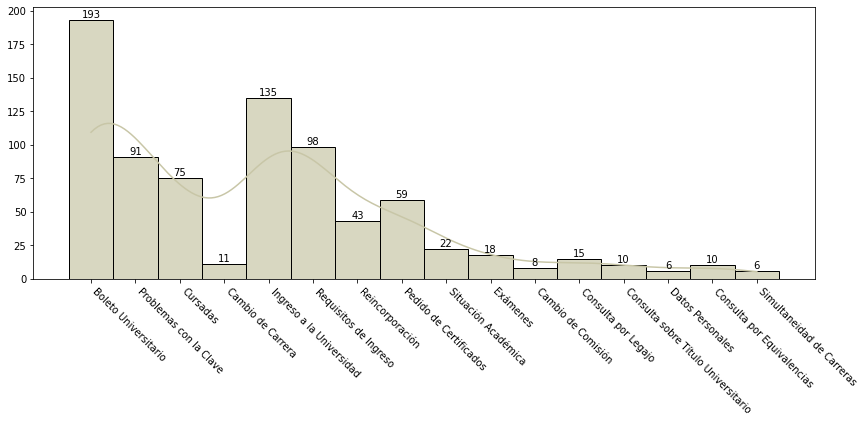

In [ ]:
from matplotlib import pyplot
import seaborn as sns

#sns.set_style('whitegrid')
plt.figure(figsize=(14,5))
#plt.tight_layout()

ax = sns.histplot(correos['clase'], kde=True, stat='count', 
                  bins=correos['clase'].unique(), binwidth=0.06, 
                  color='#c8c6a7', alpha=0.7)

ax.set_xticklabels(correos['clase'].unique(), 
                   rotation=-45, 
                   horizontalalignment='left', fontweight='light')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}\n',
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='center', color='black')

# plt.title('Histograma de clases', fontsize = 18)
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
plt.savefig('histograma.png', optimize=True, 
            transparent=True, bbox_inches = 'tight')

## 3. Pre-procesamiento:

### 3.1 Tokenización de *Consulta*

In [ ]:
import warnings 
warnings.filterwarnings(action='ignore')

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.corpus import stopwords
from string import punctuation

# Instancio la lista de stopwords en español propuesta por nltk
stop_words_es = set(stopwords.words('spanish'))

# Instancio, tokenizo y agrego puntuacion a la lista de stop_words
punkt = set(nltk.word_tokenize(punctuation))
punkt.union({'¡', '¿'})
stop_words = stop_words_es.union(punkt)

# Agrego palabras que consideramos irrelevantes
irrelevantes = {'hola', 'chau', 'gracias', 'saludos', 'adios', 'buenas', 'buen'}

# Uno los sets
stop_words = stop_words.union(irrelevantes)

# Muestro version final de stop_words
print(f'STOPWORDS: {stop_words}')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Instancio el transformador
consultas_rep = TfidfVectorizer(analyzer='word', decode_error='ignore', min_df=5,
                                strip_accents='unicode', stop_words=stop_words)

# Vectorizo y cuento las ocurrencias de Consulta
features = consultas_rep.fit_transform(correos['consulta'])

# Muestro forma y ocurrenccias
print(f'\nShape = {features.shape[0]} tuplas x {features.shape[1]} columnas.\n')
print(f'Vocabulario <\'token\':ocurrencias>:\n{consultas_rep.vocabulary_}\n')

warnings.resetwarnings()

STOPWORDS: {'adios', 'tuvieron', 'esté', 'han', 'sobre', 'hubiera', 'habrías', 'serás', 'se', '\\', 'no', 'tuvisteis', 'algunos', 'siente', 'seas', 'nosotros', 'estuvieron', 'estaréis', 'sean', 'tu', 'sentidos', 'estabas', 'estaremos', "'", 'hubieras', 'tendréis', 'hemos', 'hubiste', 'sentido', 'estuvieras', 'hay', 'habida', 'seríamos', 'tienen', 'al', 'sintiendo', 'fueses', 'estarán', 'he', ':', 'saludos', 'estarían', 'tus', 'seamos', 'teniendo', 'eran', 'este', 'esos', 'hasta', 'tened', 'sería', 'estábamos', 'habidas', '=', '^_`', 'tuvimos', 'desde', 'esta', 'un', 'estuviste', 'hubiésemos', 'tendremos', 'tuyo', 'estaríais', 'está', 'sois', 'fuesen', ')', 'tenida', '&', 'sea', 'hubieran', 'hola', 'eres', 'por', 'hayas', 'tuviese', 'estad', 'unos', 'tuviésemos', 'una', 'estar', 'habéis', '%', 'estado', 'donde', 'tanto', 'suyo', 'estuve', 'tendríamos', 'habiendo', 'tengáis', 'tenemos', 'tuviéramos', 'esas', 'estuviéramos', 'cuando', 'hubiesen', 'a', "''", 'fuimos', 'tuviste', 'habidos',

In [ ]:
# Almaceno vocabulario en un dataframe
vocabulario = pd.DataFrame(features.toarray(), columns=consultas_rep.get_feature_names())

### 3.2 Consolidación de features de las consultas y escalado

In [ ]:
# Incorporo el TF-IDF a los atributos estáticos y los consolido en X_train
X_train, y_train = consolidar_df(correos, vocabulario, 'consulta', 'clase')

In [ ]:
# Escalado Min-Max (ahora todos los atributos)
# Quiero lograr que pierdan fuerza los estáticos
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Mantengo el tipo de dato DataFrame
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)

X_train.head()

,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,10,12,1er,2016,2017,2018,2019,22,abril,academica,academicos,acceder,acceso,acerca,acercarme,acredita,acredito,acuerdo,...,tambien,tampoco,tarda,tarde,tardes,tarifa,tarjeta,tema,tendria,tener,tenia,terminal,tiempo,titulo,toda,todavia,trabajo,tramitar,tramite,tramites,ud,ultima,universidad,universitario,unlu,urgente,ustedes,usuario,va,vacunas,van,varias,varios,veces,ver,vez,via,volver,voy,web
0,1.000000,0.25,0.181818,0.0,1.00,0.666667,0.857143,1.00,1.0,1.0,0.051724,0.307692,0.200883,0.0,0.547724,0.250000,0.18,0.148649,0.929252,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.768934,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.628347,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
1,0.666667,0.25,1.000000,1.0,0.00,0.000000,0.142857,0.25,1.0,1.0,0.086207,0.461538,0.889625,0.0,0.664658,0.000000,0.75,0.594595,0.580952,0.079952,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.260251,0.229111,0.0,0.0,0.0,0.0,0.320836,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.268032
2,0.166667,0.25,0.272727,0.0,1.00,1.000000,1.000000,1.00,1.0,1.0,0.051724,0.461538,0.176600,0.0,0.567170,0.083333,0.19,0.189189,0.797403,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
3,0.500000,0.75,0.818182,1.0,0.75,0.333333,0.428571,0.50,1.0,1.0,0.051724,0.461538,0.869757,0.0,0.701254,0.416667,0.67,0.445946,0.596735,0.136179,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.928803,0.0,0.0,0.0,0.322503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214579,0.0,0.0,0.0,0.0,0.391807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.303455,0.000000,0.0,0.000000
4,0.333333,0.00,0.090909,0.0,1.00,0.000000,0.142857,0.00,0.0,1.0,0.931034,0.461538,0.350993,0.0,0.672927,0.083333,0.29,0.202703,0.814286,0.127619,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.389489,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.418001,0.0,0.000000


## 4. Evaluación de los atributos importantes por Clase

### 4.1 Evaluación de palabras más importantes por _clase_

En primer lugar recalculamos el dataframe, agrupando los términos y su pesado (media) por clase. La idea es realizar una sumatoria por términos y clase para evaluar los términos más _utilizados_ para cada clase.

Esta idea se toma de _Text classification by labeling words (2004)_ [3] reemplazando la idea de tomar los términos más importantes de cada clase a partir del juicio de expertos por la exploración de los términos que más aparecen a partir del análisis de los ejemplos etiquetados.

In [ ]:
df_terminos = pd.concat([X_train.iloc[:, 22:], pd.DataFrame(y_train, columns=['clase'])], axis=1).groupby(['clase']).mean().reset_index()
df_terminos.head()

,clase,10,12,1er,2016,2017,2018,2019,22,abril,academica,academicos,acceder,acceso,acerca,acercarme,acredita,acredito,acuerdo,administracion,agradeceria,aguardo,ahora,algun,alguna,alumna,alumno,analitico,ano,anos,anotar,anotarme,anote,anterior,aparece,aparecen,aparezco,aprobadas,aprobe,asi,...,tambien,tampoco,tarda,tarde,tardes,tarifa,tarjeta,tema,tendria,tener,tenia,terminal,tiempo,titulo,toda,todavia,trabajo,tramitar,tramite,tramites,ud,ultima,universidad,universitario,unlu,urgente,ustedes,usuario,va,vacunas,van,varias,varios,veces,ver,vez,via,volver,voy,web
0,Boleto Universitario,0.00000,0.002706,0.000000,0.000000,0.0,0.007190,0.003278,0.006026,0.011647,0.0,0.002786,0.021970,0.0,0.008553,0.000000,0.02361,0.034657,0.000000,0.000000,0.012593,0.006575,0.027954,0.031162,0.013890,0.005181,0.002383,0.00000,0.060931,0.007869,0.0,0.001323,0.0,0.013319,0.040773,0.000000,0.002425,0.000000,0.002979,0.026550,...,0.003589,0.008927,0.000000,0.009810,0.067817,0.017198,0.056867,0.024510,0.005181,0.021781,0.056855,0.036630,0.022867,0.0,0.0,0.020820,0.000000,0.031718,0.168545,0.016286,0.0,0.008653,0.034297,0.022414,0.029245,0.004567,0.026406,0.008986,0.013462,0.0,0.012155,0.004175,0.011223,0.0,0.006924,0.025253,0.002335,0.020948,0.021409,0.009736
1,Cambio de Carrera,0.07111,0.000000,0.000000,0.143393,0.0,0.036386,0.000000,0.000000,0.032752,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.058800,0.038746,0.000000,0.000000,0.000000,0.000000,0.046074,0.039235,0.000000,0.00000,0.056232,0.000000,0.0,0.051208,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.145285,...,0.000000,0.000000,0.000000,0.000000,0.149398,0.000000,0.000000,0.000000,0.000000,0.000000,0.054832,0.000000,0.055468,0.0,0.0,0.023781,0.026006,0.000000,0.000000,0.000000,0.0,0.000000,0.019711,0.000000,0.000000,0.063926,0.046683,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.072278,0.000000,0.000000,0.174226,0.000000,0.000000
2,Cambio de Comisión,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.103337,0.00000,0.000000,0.000000,0.056089,0.000000,0.000000,0.000000,0.000000,0.206475,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.123913,0.062407,0.000000,0.000000,0.085994,0.000000,0.000000,0.000000,0.108922,0.171528,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Consulta por Equivalencias,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.143839,0.000000,0.000000,0.000000,0.000000,0.154194,0.000000,0.000000,0.04259,0.026253,0.000000,0.0,0.000000,0.0,0.084023,0.000000,0.054885,0.000000,0.050145,0.095705,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.104338,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.119732,0.067932,0.0,0.000000,0.000000,0.000000,0.151674,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.048952,0.000000,0.000000,0.000000,0.000000,0.000000
4,Consulta por Legajo,0.00000,0.000000,0.066667,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.056102,0.0,0.000000,0.060660,0.00000,0.000000,0.031026,0.000000,0.000000,0.000000,0.028822,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.035642,0.000000,0.228693,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043115,0.0,0.0,0.032292,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.027772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.023799,0.000000,0.000000,0.000000,0.000000,0.000000


Se define una función para el ploteo del wordcount con algunos parámetros básicos:

#### Librerías y función útil

Se definen las librerías de dibujo a utilizar y una función de plot con parámetros básicos:

In [ ]:
# Se importan las librerías gráficas
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

def plot_cloud(wordcloud, titulo):
    # Set figure size
    plt.figure(figsize=(10, 8))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    # Titulo
    plt.title(titulo)
    # Muestro el gráfico
    plt.show()

/usr/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/lib/python3.7/dist-packages/wordcloud/wordcloud.py:30: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


### 4.2 Términos más importantes y WordCloud

A continuación se itera en cada una de las clases, calculando un ranking con los N términos más importantes para cada clase y se realiza un WordCloud con los términos utilizados en cada clase (se descartan los frecuencia=0): <br />
(esta porción de código amerita refactoring)

Se crea una lista con las diferentes clases para recorrer clase a clase en búsqueda de los términos importantes:

In [ ]:
clases = correos.clase.unique()


Clase: Boleto Universitario
5 términos más importantes:
          termino     valor
56        boleto  0.315932
160  estudiantil  0.285189
54     beneficio  0.215488
386         sube  0.208252
407      tramite  0.168545


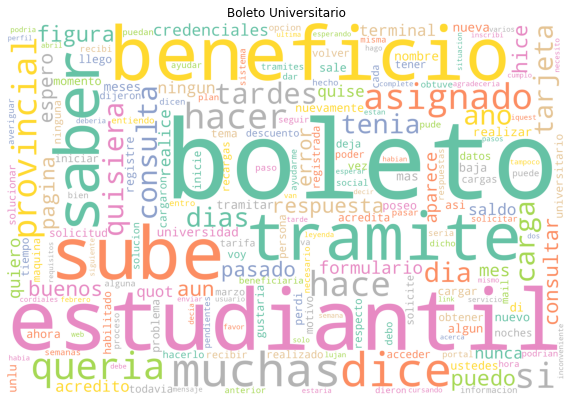


Clase: Problemas con la Clave
5 términos más importantes:
         termino     valor
72        clave  0.278358
236        mail  0.177505
89   contrasena  0.166733
200    ingresar  0.133667
275      olvide  0.130279


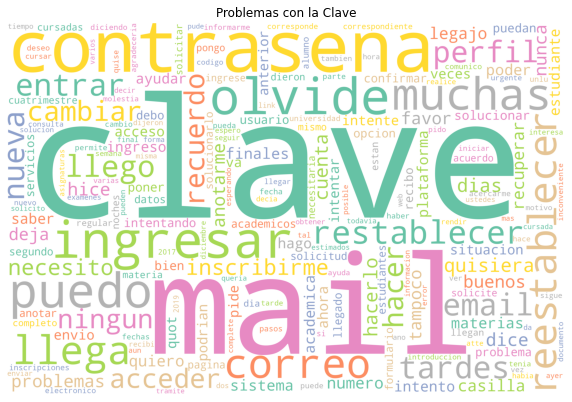


Clase: Cursadas
5 términos más importantes:
          termino     valor
244     materias  0.220714
328       queria  0.130330
327        puedo  0.126897
208  inscribirme  0.126505
356        saber  0.120258


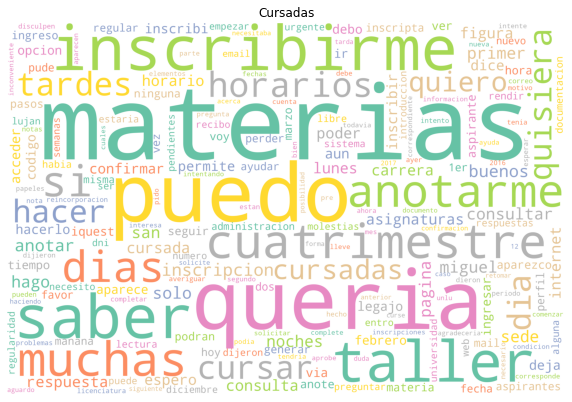


Clase: Cambio de Carrera
5 términos más importantes:
        termino     valor
67     carrera  0.344134
61      cambio  0.276186
60   cambiarme  0.201854
256     muchas  0.182391
426     volver  0.174226


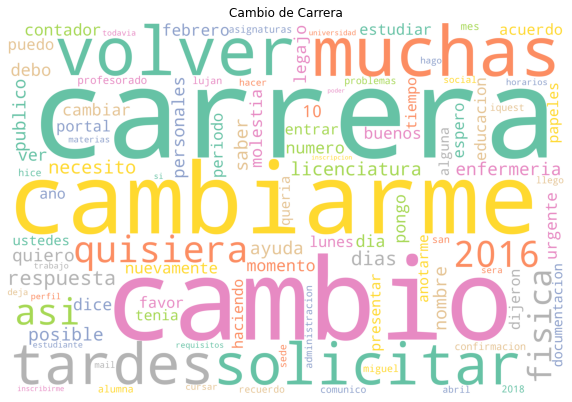


Clase: Ingreso a la Universidad
5 términos más importantes:
          termino     valor
236         mail  0.163266
91        correo  0.125998
209  inscripcion  0.112941
228        llega  0.091323
393       tardes  0.082550


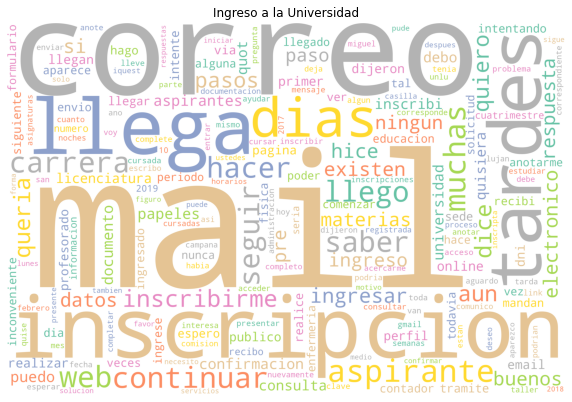


Clase: Requisitos de Ingreso
5 términos más importantes:
         termino     valor
350  requisitos  0.237135
122        dice  0.173230
200    ingresar  0.142517
244    materias  0.132046
99       cumple  0.130410


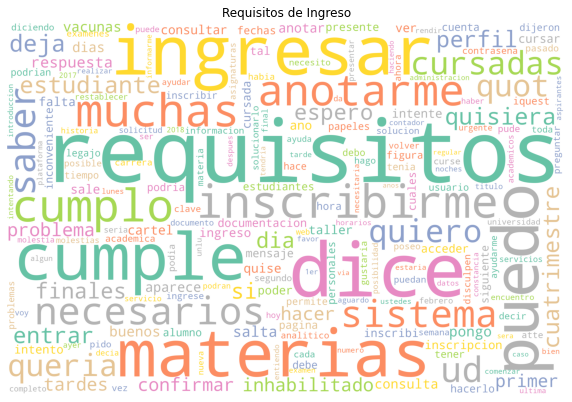


Clase: Reincorporación
5 términos más importantes:
      termino     valor
345  regular  0.150437
185    hacer  0.129207
329   quiero  0.123799
67   carrera  0.114054
256   muchas  0.105244


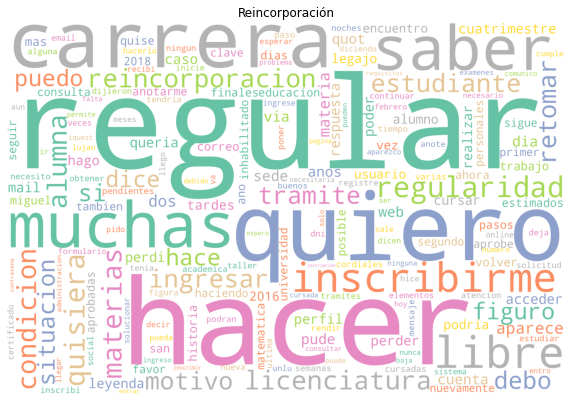


Clase: Pedido de Certificados
5 términos más importantes:
          termino     valor
37     aprobadas  0.315865
244     materias  0.304347
305   porcentaje  0.285255
71   certificado  0.267395
27     analitico  0.136192


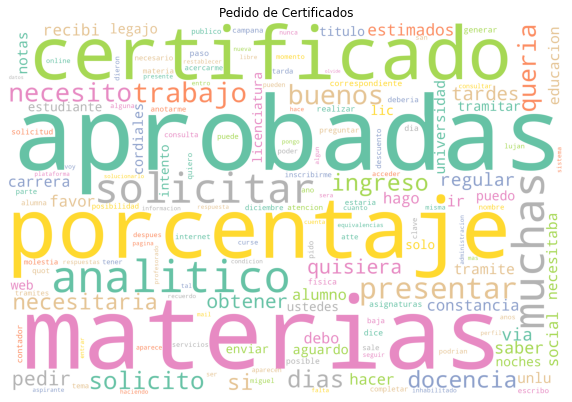


Clase: Situación Académica
5 términos más importantes:
        termino     valor
266       nota  0.229066
10   academica  0.214259
376  situacion  0.195981
356      saber  0.174462
256     muchas  0.167902


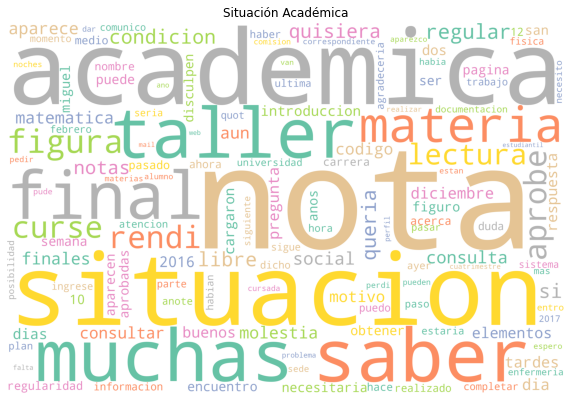


Clase: Exámenes
5 términos más importantes:
     termino     valor
172   final  0.379445
162  examen  0.250864
349  rendir  0.185047
356   saber  0.171132
393  tardes  0.152211


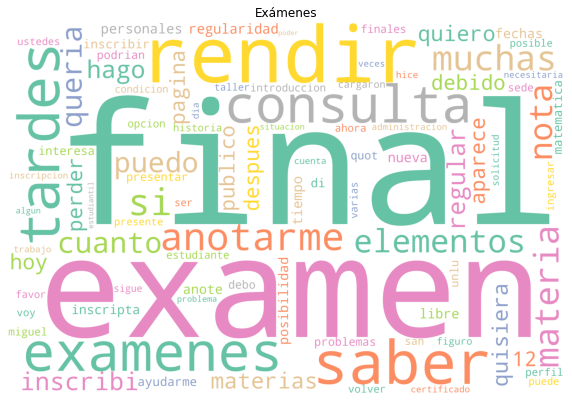


Clase: Cambio de Comisión
5 términos más importantes:
        termino     valor
76    comision  0.557748
60   cambiarme  0.324966
356      saber  0.276070
185      hacer  0.247664
328     queria  0.232506


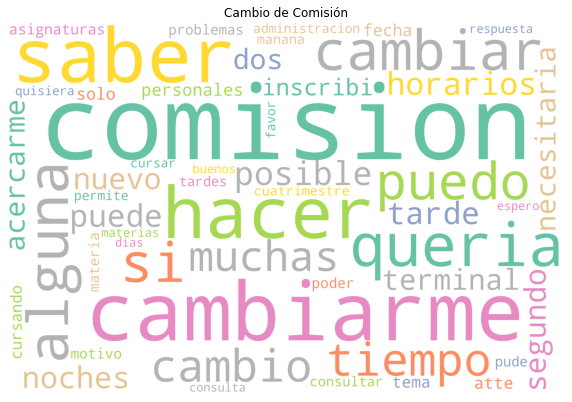


Clase: Consulta por Legajo
5 términos más importantes:
          termino     valor
222       legajo  0.568592
271       numero  0.326152
393       tardes  0.228693
256       muchas  0.150885
260  necesitaria  0.126941


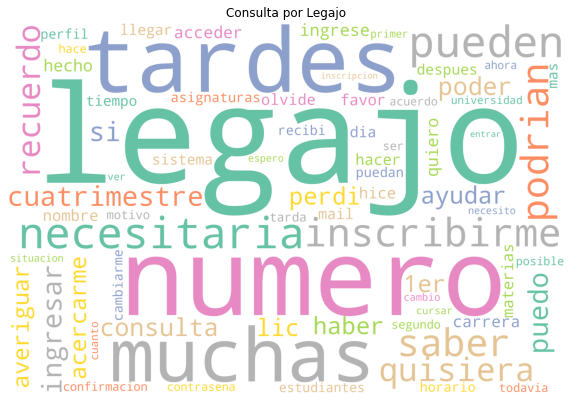


Clase: Consulta sobre Título Universitario
5 términos más importantes:
       termino     valor
402    titulo  0.566775
407   tramite  0.275815
278    pagina  0.202062
410    ultima  0.185860
406  tramitar  0.170020


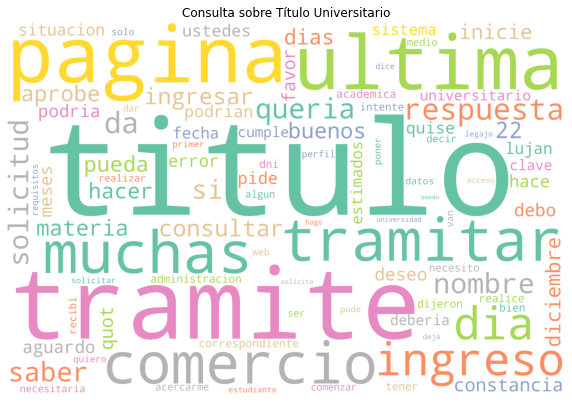


Clase: Datos Personales
5 términos más importantes:
      termino     valor
91    correo  0.326005
251    mismo  0.317727
236     mail  0.181161
59   cambiar  0.166667
108    datos  0.166667


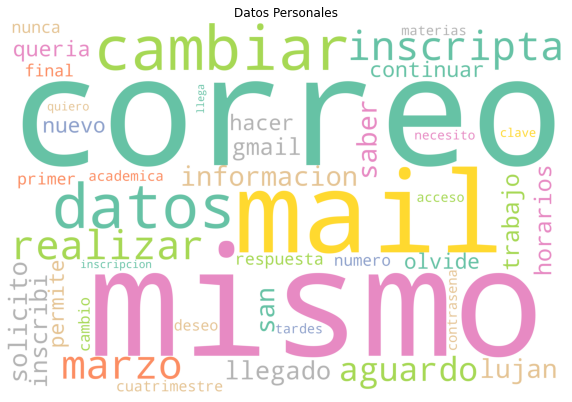


Clase: Consulta por Equivalencias
5 términos más importantes:
            termino     valor
149  equivalencias  0.613924
256         muchas  0.396858
356          saber  0.289585
381      solicitud  0.266571
371             si  0.196496


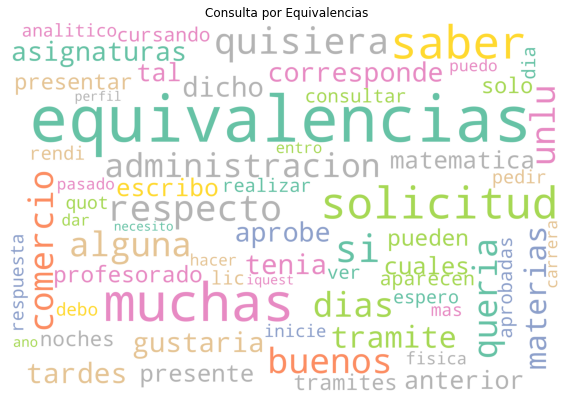


Clase: Simultaneidad de Carreras
5 términos más importantes:
            termino     valor
374  simultaneidad  0.558560
87        contador  0.340737
135            dos  0.306087
282          pasar  0.277079
222         legajo  0.256338


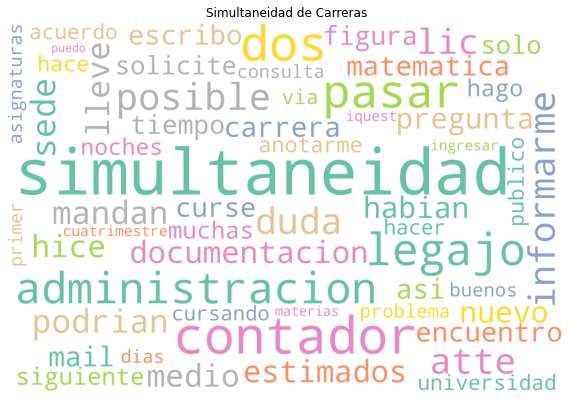

In [ ]:
N = 5

for clase_iter in clases:
  # Defino la clase a tratar
  print('\nClase: {}'.format(clase_iter))

  # Transpongo la fila en columna
  terminos_clase = df_terminos[df_terminos['clase']==clase_iter].transpose().reset_index()

  # Renombro las columnas
  terminos_clase.columns = ['termino', 'valor']

  # Elimino el valor de la clase
  terminos_clase = terminos_clase.loc[terminos_clase['termino']!='clase']

  # Paso a numérica la columna
  terminos_clase['valor'] = pd.to_numeric(terminos_clase['valor'])

  # Muestro los N más importantes para la clase
  print('{} términos más importantes:\n {}'.format(N, terminos_clase.nlargest(N,'valor')))

  # Se preparan los datos para el WordCloud
  df_dis0 = terminos_clase.loc[terminos_clase['valor']>0]
  disctint0 = pd.Series(df_dis0.valor.values,index=df_dis0.termino).to_dict()

  # Genera la wordcloud
  wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False).generate_from_frequencies(disctint0)
  plot_cloud(wordcloud, clase_iter)

## 4.2.1 Persistencia de términos más importantes por clase

Se genera un txt para cada clase con los términos más importantes según TF-IDF:

In [ ]:
!mkdir txts_tfidf

In [ ]:
# Se define la cantidad de términos a utilizar por clase 
N = 20

for clase_iter in clases:

  # Transpongo la fila en columna
  terminos_clase = df_terminos[df_terminos['clase']==clase_iter].transpose().reset_index()

  # Renombro las columnas
  terminos_clase.columns = ['termino', 'valor']

  # Elimino el valor de la clase
  terminos_clase = terminos_clase.loc[terminos_clase['termino']!='clase']

  # Paso a numérica la columna
  terminos_clase['valor'] = pd.to_numeric(terminos_clase['valor'])

  terminos_clase.sort_values(by='valor', ascending=False, inplace=True)

  terminos_clase_topN = terminos_clase.head(N)
  # Guardo los términos importantes para la clase con su ponderación en un txt
  print(f'Se genera el txt de la clase {clase_iter}.')
  txt_name = "txts_tfidf/" + clase_iter + ".txt"
  terminos_clase_topN.to_csv(txt_name, sep=',', index=False)

Se genera el txt de la clase Boleto Universitario.
Se genera el txt de la clase Problemas con la Clave.
Se genera el txt de la clase Cursadas.
Se genera el txt de la clase Cambio de Carrera.
Se genera el txt de la clase Ingreso a la Universidad.
Se genera el txt de la clase Requisitos de Ingreso.
Se genera el txt de la clase Reincorporación.
Se genera el txt de la clase Pedido de Certificados.
Se genera el txt de la clase Situación Académica.
Se genera el txt de la clase Exámenes.
Se genera el txt de la clase Cambio de Comisión.
Se genera el txt de la clase Consulta por Legajo.
Se genera el txt de la clase Consulta sobre Título Universitario.
Se genera el txt de la clase Datos Personales.
Se genera el txt de la clase Consulta por Equivalencias.
Se genera el txt de la clase Simultaneidad de Carreras.


Guardo los archivos en Drive:

In [ ]:
import shutil
shutil.make_archive('txts_tfidf', 'zip', 'txts_tfidf')

ENTORNO='Colab'
if ENTORNO=='Colab':
  from google.colab import drive
  drive.mount('drive')
  !cp txts_tfidf.zip "drive/My Drive/"

Mounted at drive


### 4.3 Prueba de Chi-cuadrado

Se realiza un Test de Chi-cuadrado para verificar dependencia entre features y clases.

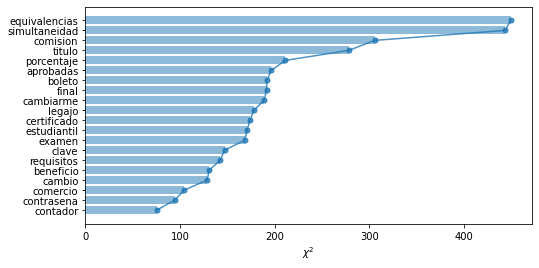

In [ ]:
# Analizo cuales son las features mas importantes según chi2
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
%matplotlib inline

# Inicializo el tamaño del gráfico
plt.figure(figsize=(8,4))

# chi2[0]: devuelve el score por cada feature
# chi2[1]: devuelve el p-value por score
chi2score = chi2(X_train, y_train)[0]

# Los paso a clave valor (feature, score_chi2)
scores = list(zip(X_train.columns, chi2score))

# Ordeno los scores (de menor a mayor)
chi2 = sorted(scores, key=lambda x:x[1])

# Me quedo con los últimos N (los mas grandes)
N=20
topchi2 = list(zip(*chi2[-N:]))

# Convierto en intervalo el total para la cantidad de barras del gráfico
x_chi = range(len(topchi2[1]))

# Tomo los labels
labels = topchi2[0]

# Grafico en función de los scores
plt.barh(x_chi, topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x_chi, '-o', markersize=5, alpha=0.8)
plt.yticks(x_chi, labels)

# Pongo el xlabel
plt.xlabel(r'$\chi^2$')

# Muestro el gráfico
plt.show();

# Referencias:
1. [Presentación](0) de apoyo al [Proyecto de Investigación](1) "Clasificación automática de correos electrónicos".

2. Clasificacion de textos por etiquetado de palabras: [short paper](2).

3. [API](3) del diccionario Collins.

4. [Funciones](4) de la [API](3) del diccionario Collins.

5. Librería [clusteval](5) para la evaluación KMeans.

[0]:https://docs.google.com/presentation/d/1-gdZ3dUI2pAfXM6Bgau53U7G4g2Bkv6DlxGESnu7A20/edit?usp=sharing 
[1]:https://github.com/jumafernandez/clasificacion_correos 
[2]:https://www.aaai.org/Papers/AAAI/2004/AAAI04-068.pdf
[3]:https://pypi.org/project/collins-client/
[4]:https://api.collinsdictionary.com/api/v1/documentation/html
[5]:https://clusteval.sdu.dk/1/mains

# Papers:
1. Ali, R. S. H., & El Gayar, N. (2019, December). Sentiment Analysis using Unlabeled Email data. In 2019 International Conference on Computational Intelligence and Knowledge Economy (ICCIKE) (pp. 328-333). IEEE.
1. Gupta, I., & Joshi, N. (2020). Real-time twitter corpus labelling using automatic clustering approach. International Journal of Computing and Digital Systems, 9, 1-9.
1. Liu, B., Li, X., Lee, W. S., & Yu, P. S. (2004, July). Text classification by labeling words. In AAAI (Vol. 4, pp. 425-430).
1. Liu, S., & Lee, I. (2018). Email sentiment analysis through k-means labeling and support vector machine classification. Cybernetics and Systems, 49(3), 181-199.
